
# Basic Overview
The objective is to see if we can squeeze out some more predictive power from logistic regression, random forest and
xgboot models via ensembling.

Comments/criticisms/appreciations are greatly accepted and appreciated. Do not be shy and send me an email at babinu@gmail.com !

Source of data : https://www.kaggle.com/c/titanic/data

In [80]:
import pandas as pd
import numpy as np
import os
import re

In [81]:
files = [f for f in os.listdir('.') if re.match('kaggle_out.*\.csv', f)]

files = [
         '../learn_from_aashita/kaggle_out_xgboost_my_attempt_detailed_fine_tuning.csv',
        '../learn_from_oscar/kaggle_out_tickets_svc.csv',
        '../learn_from_oscar/kaggle_out_names_svc.csv']
print(files)
count = 0
master_df = pd.DataFrame()
count_to_file_name = dict()
for  csv_file in files:
    count += 1
    data_df = pd.read_csv(csv_file)
    column_name = 'Survived_or_not_model_' + str(count)

    survived_list = data_df['Survived'].values
    master_df[column_name] = survived_list
    master_df['PassengerId'] = data_df['PassengerId'].values
    count_to_file_name[count] = csv_file
    prev_survived_list = survived_list

['../learn_from_aashita/kaggle_out_xgboost_my_attempt_detailed_fine_tuning.csv', '../learn_from_oscar/kaggle_out_tickets_svc.csv', '../learn_from_oscar/kaggle_out_names_svc.csv']


In [82]:
relevant_cols = [col for col in master_df.columns if col not in ['PassengerId']]

master_df[relevant_cols].corr()

,Survived_or_not_model_1,Survived_or_not_model_2,Survived_or_not_model_3
Survived_or_not_model_1,1.000000,0.183321,0.875787
Survived_or_not_model_2,0.183321,1.000000,0.255624
Survived_or_not_model_3,0.875787,0.255624,1.000000


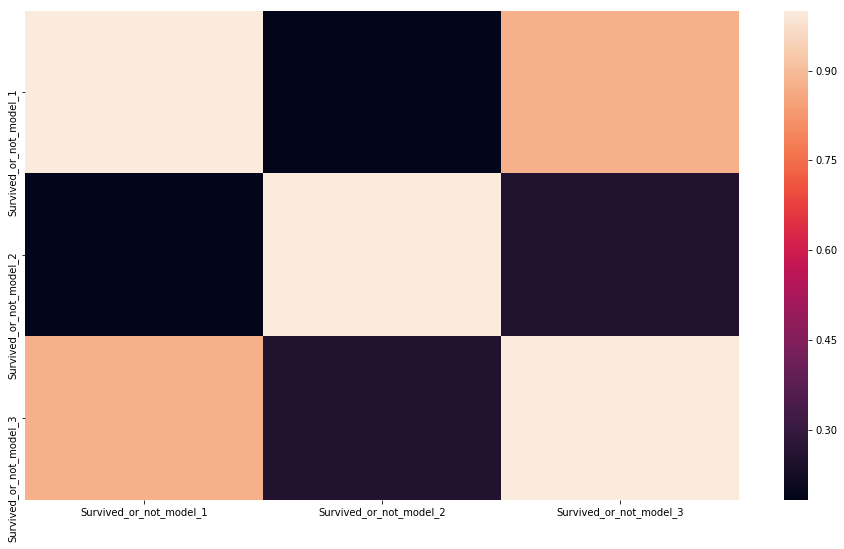

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.heatmap(master_df[relevant_cols].corr(), ax=ax)

### Comment
The correlation is relatively, but let us still go with ensembling and see what we get (for more details see https://mlwave.com/kaggle-ensembling-guide/)

In [84]:
def get_most_frequent_entry(a, b, c):
    sum_vals = a + b + c
    
    if sum_vals <= 1:
        frequent_val = 0
    else:
        frequent_val = 1
    return frequent_val

In [85]:
master_df['Survived_or_not_ensembled'] = master_df.apply(
    lambda x : get_most_frequent_entry(x['Survived_or_not_model_1'], 
                                       x['Survived_or_not_model_2'], 
                                       x['Survived_or_not_model_3']), axis=1)

In [86]:
master_df.sort_values(by=['PassengerId'], inplace=True)

In [87]:
# Check with out of sample of data (to be submitted to kaggle.)
test_data = pd.read_csv("../input/test_data_processed_correct.csv")
test_data['Predictions'] = master_df['Survived_or_not_ensembled']
sucess_rate = (np.sum(test_data['Survived'] == test_data['Predictions'])/len(test_data))
print("Success rate of model on test data is {0:0.3g}".format(sucess_rate))

Success rate of model on test data is 0.799


In [88]:
# We notice that the success rate is same as in the case when we used xgboost models alone.
# Let us confirm the same.
print("Number of passengers whose survivorship is to be predicted is {0}".format(len(master_df)))

for i in range(len(files)):
    index = i + 1
    rel_csv_file = count_to_file_name.get(index)
    print("Rel file is {0}".format(rel_csv_file))    
    single_model_prediction_col = 'Survived_or_not_model_' + str(index)
    num_common_entries = np.sum(master_df[single_model_prediction_col] == master_df['Survived_or_not_ensembled'])
    print("Number of entries with common prediction as that of the ensembled model is {0}".format(num_common_entries))    
    

Number of passengers whose survivorship is to be predicted is 418
Rel file is ../learn_from_aashita/kaggle_out_xgboost_my_attempt_detailed_fine_tuning.csv
Number of entries with common prediction as that of the ensembled model is 401
Rel file is ../learn_from_oscar/kaggle_out_tickets_svc.csv
Number of entries with common prediction as that of the ensembled model is 290
Rel file is ../learn_from_oscar/kaggle_out_names_svc.csv
Number of entries with common prediction as that of the ensembled model is 411


### Conclusion
We do look to be getting some differences in the ensembled model(though the total accuracy remained same as that of the xgboost model). Let us generate and submit predictions to kaggle.

In [89]:
predictions_to_kaggle = test_data[['PassengerId', 'Predictions']].copy()
#predictions_to_kaggle.rename(columns={'Predictions' : 'Survived'}, inplace=True)
#predictions_to_kaggle.to_csv('kaggle_out_ensemble_xgboost_rft_logreg.csv', index=False)
predictions_to_kaggle.to_csv('kaggle_out_ensemble_aashita_oscar.csv', index=False)
#predictions_to_kaggle.to_csv('kaggle_out_ensemble_all_oscar.csv', index=False)
#predictions_to_kaggle.to_csv('kaggle_out_ensemble_least_corr.csv', index=False)